In [1]:
##   Load Packages
using BayesianNonparametricStatistics, Plots
using Statistics, Distributions
using DelimitedFiles, Plots, LaTeXStrings
using NBInclude, LinearAlgebra, SparseArrays
##   Colors
lblue = RGBA(83/255, 201/255, 250/255,0.7)
dblue = RGBA(47/255, 122/255, 154/255,0.7)

In [2]:
##   Load Data
df = DelimitedFiles.readdlm("butane_data.txt", '\n',  ' ')
df = df[:,1]
#Subsampling to indexes
#X_1, X_1001, X_2001,...
indexes = [1:1000:4*10^6;]
df = df[indexes]

4000-element Vector{Float64}:
  0.099379
  0.004472
 -0.021587
  0.258075
  0.276441
  0.196464
 -0.010677
  0.154276
  0.35946
 -0.06857
  0.258267
  0.716058
 -2.305957
  ⋮
 -0.157114
  0.025924
 -0.202653
 -0.0729
  0.315765
 -1.88634
 -2.133324
 -0.989599
  0.181816
  0.02064
  0.208227
  1.935936

In [3]:
# Scale data to be 1-periodic
x_path = (df).+pi
x_path = (df).*1/(2*pi)

4000-element Vector{Float64}:
  0.015816659089529467
  0.000711740905506956
 -0.0034356777565247446
  0.04107391193844089
  0.04399695162326664
  0.03126821673960613
 -0.0016992973273921668
  0.024553788000445245
  0.0572098358438127
 -0.010913254447811264
  0.041104469687514536
  0.11396417024049639
 -0.3670044551073577
  ⋮
 -0.025005469728940046
  0.004125932744714295
 -0.03225322668240187
 -0.011602395351399172
  0.050255560605412336
 -0.30022033535196585
 -0.33952905981657455
 -0.15749957252879654
  0.028936915133196045
  0.0032849580254167197
  0.03314035633519609
  0.3081137839095515

In [4]:
# Estimate sigma^2
# sum (v_i-v_i+1)^2
sig_est = zeros(3999)

for i in 1:3999
    sig_est[i] = (x_path[i+1]-x_path[i])^2
end
# Estimate T for unit diffusion
T = 1/sum(sig_est)

sigma_hat = sum(sig_est)/4.0

eta = 0.02*T^2*2*pi
alph = 3/2
s = 1/(sqrt(eta)*pi^2 )

# Change time scale for unit diffusion
time_t = [i*T for i in 0:3999]

x_data = SamplePath(time_t, x_path)

##   Model
#[0,4] nanoseconds
σ = 1.0/(2*pi)
beginvalue = 0.0
endtime = 3.9999#*10^-9
Δ = (4.0/4000)#*10^-9


model = SDEModel(σ, beginvalue , endtime ,  Δ)

SDEModel{Float64}(0.15915494309189535, 0.0, 3.9999, 0.001)

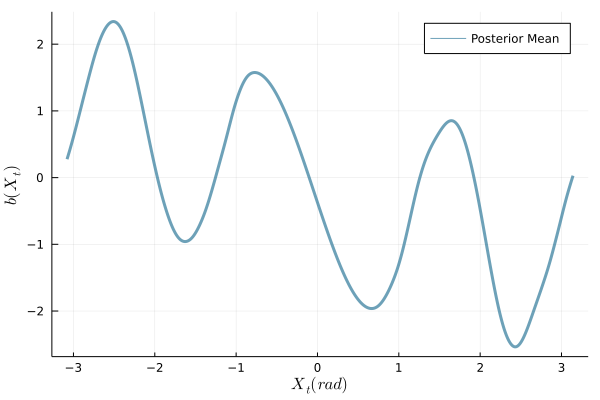

In [17]:
# Number of terms in the series
# sum_k=1^J s*k^-2*Z_k*phi_k
J = 200

# Distribution of theta in
# sum_j theta_j*phi_j
distribution = GaussianVector(diagm([(s*0.5)*k^(-2) for k in 1.0:(J+1)]))

##   Basis functions
# Fourier
Π = GaussianProcess(vcat([x ->1.0] , [fourier(k) for k in 1:J]), distribution)


##   Posterior
postΠ = calculateposterior(Π, x_data, model)
# Posterior Mean
theta = mean(postΠ)
# x values [0,1]
x_vals = [0.01:0.001:1;]
# Plot posterior mean
bayes_post = plot(x_vals.*2*pi.-pi, theta.(x_vals.*(-1).-1), #note .*2pi to get the function on the scale of [0,2pi]
                            #instead of [0,1]
    linewidth = 3,
    linecolor = dblue,
    label = "Posterior Mean")
xlabel!("\$X_t(rad)\$")
ylabel!("\$b(X_t)\$")

In [52]:
multiplot = plot()

for sig in range(1/(2pi),3, length = 5)
    model = SDEModel(sig, beginvalue , endtime ,  Δ)
    for i in 1:20
        # Distribution of theta in
        # sum_j theta_j*phi_j
        distribution = GaussianVector(diagm([(i)*k^(-2) for k in 1.0:(J+1)]))

        ##   Basis functions
        # Fourier
        Π = GaussianProcess(vcat([x ->1.0] , [fourier(k) for k in 1:J]), distribution)


        ##   Posterior
        postΠ = calculateposterior(Π, x_data, model)
        # Posterior Mean
        theta = mean(postΠ)
        # x values [0,1]
        x_vals = [0.01:0.001:1;]
        # Plot posterior mean
        tmp_plot = plot(x_vals.*2*pi.-pi, theta.(x_vals.*(-1).-1), #note .*2pi to get the function on the scale of [0,2pi]
                                    #instead of [0,1]
            linewidth = 3,
            linecolor = dblue,
            label =string(i),
            linealpha = 0.3)
        png(tmp_plot, string(sig,i))
    end
end